# Demo: Mapping Luhman 16B with NIRSpec

In this tutorial, we will demonstrate how to use `spectralmap` to analyze time-series observations. We will use a sequence of NIRSpec observations of the brown dwarf Luhman 16B to recover a spectroscopic map of its surface.

**We will cover:**
1. Loading and preprocessing the lightcurve data.
2. Inverting the lightcurves to obtain surface maps.
3. Clustering the map pixels to identify distinct spectral regions.
4. Extracting and analyzing the spectra of these regions.

Let's get started!

In [1]:
import numpy as np
print(np.__version__)
np.bool = bool
import starry
starry.config.lazy = False  # disable lazy evaluation
starry.config.quiet = True  # disable warnings

1.21.1


WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
/opt/miniconda3/envs/spectralmap/lib/python3.9/site-packages/starry/_core/ops/limbdark/base_op.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/opt/miniconda3/envs/spectralmap/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 8,
    "axes.labelsize": 8,    
    "axes.titlesize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "lines.linewidth": 1.0,
    "axes.linewidth": 0.8,
    "figure.dpi": 300,
    "figure.figsize": (3.5, 2.5),  # ApJ column width ~3.5 in; double column ~7 in
})
import spectralmap
print(f"spectralmap version: {spectralmap.__version__}")

spectralmap version: 0.1.0


## 1. Load Data
We load the NIRSpec lightcurve files. Each file corresponds to a specific rotation phase (angle). We will read them in, sort them by phase, and normalize the flux.

In [3]:
import numpy as np
from spectralmap.utilities import bin_flux_by_theta

# 1. Load the 2023 and 2024 data files
file_2023 = "data/Luhman16b_NIRSpec_2023.npz"
file_2024 = "data/Luhman16b_NIRSpec_2024.npz"

d23 = np.load(file_2023)
d24 = np.load(file_2024)

theta_2023 = np.asarray(d23["theta"])
theta_2024 = np.asarray(d24["theta"])
wl = d24["wl"]
flux_raw = d24["flux_raw"]
flux_err = d24["flux_err"]

# 2. Estimate phase shift using circular cross-correlation of broadband light curves
lc_2023 = np.nanmean(d23["flux_raw"], axis=0)
lc_2024 = np.nanmean(d24["flux_raw"], axis=0)

def periodic_interp(theta_deg, values, grid_deg):
    order = np.argsort(theta_deg)
    x = theta_deg[order]
    y = values[order]
    x_ext = np.concatenate([x - 360, x, x + 360])
    y_ext = np.concatenate([y, y, y])
    return np.interp(grid_deg, x_ext, y_ext)

phase_grid = np.linspace(0, 360, 720, endpoint=False)
ref = periodic_interp(theta_2023, lc_2023, phase_grid)
ref = (ref - np.nanmean(ref)) / np.nanstd(ref)

candidate_shifts = np.linspace(-180, 180, 1441)
corr = np.empty(candidate_shifts.size)

for i, shift_deg in enumerate(candidate_shifts):
    shifted_theta_2024 = (theta_2024 + shift_deg)
    cur = periodic_interp(shifted_theta_2024, lc_2024, phase_grid)
    cur = (cur - np.nanmean(cur)) / np.nanstd(cur)
    corr[i] = np.nanmean(ref * cur)

best_shift_deg = float(candidate_shifts[np.nanargmax(corr)])
print(f"Best 2024→2023 phase shift from cross-correlation: {best_shift_deg:.2f} deg")

# 3. Apply inferred shift to 2024 phases
theta = (theta_2024 + best_shift_deg)

# 4. Normalize and bin
amplitudes = np.nanmean(flux_raw, axis=1)
flux = (flux_raw.T / amplitudes).T
theta, flux, flux_err, counts = bin_flux_by_theta(theta, flux, n_bins=64, flux_err=flux_err)

Best 2024→2023 phase shift from cross-correlation: 9.00 deg


## 2. Inversion with SpectralMap

First, we organize the data into a `LightCurveData` object. We must specify the inclination of the object (here assumed to be 80 degrees).

In [4]:
from spectralmap.mapping import LightCurveData, make_map
data = LightCurveData(theta=theta, flux=flux, flux_err=flux_err, inc=90)

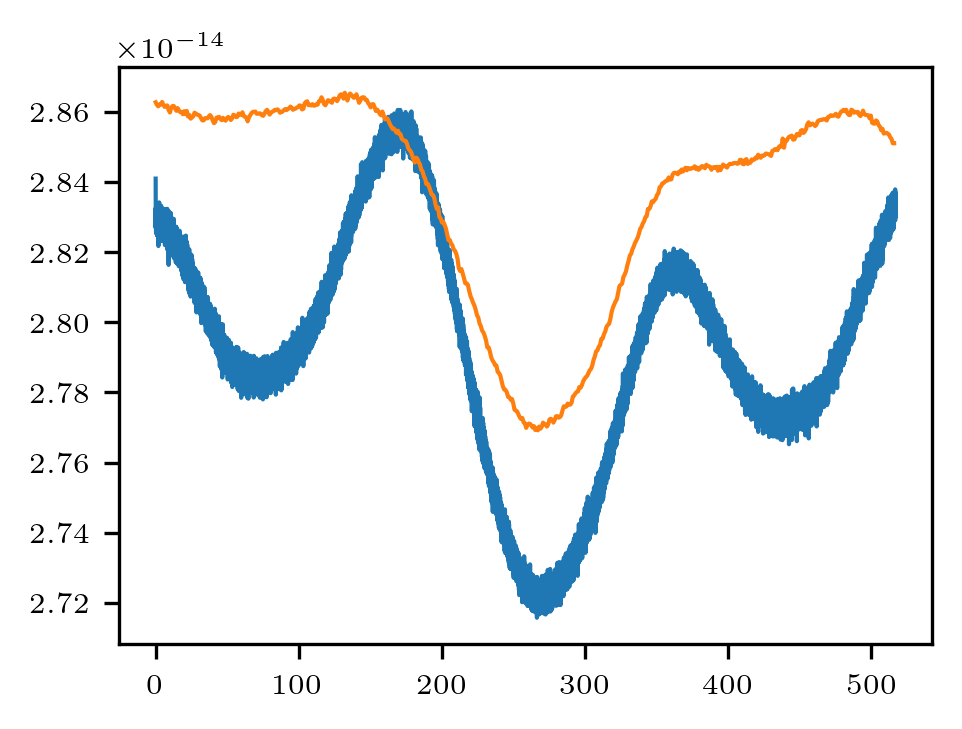

In [5]:
plt.plot(theta_2023, lc_2023)
plt.plot(theta_2024, lc_2024)

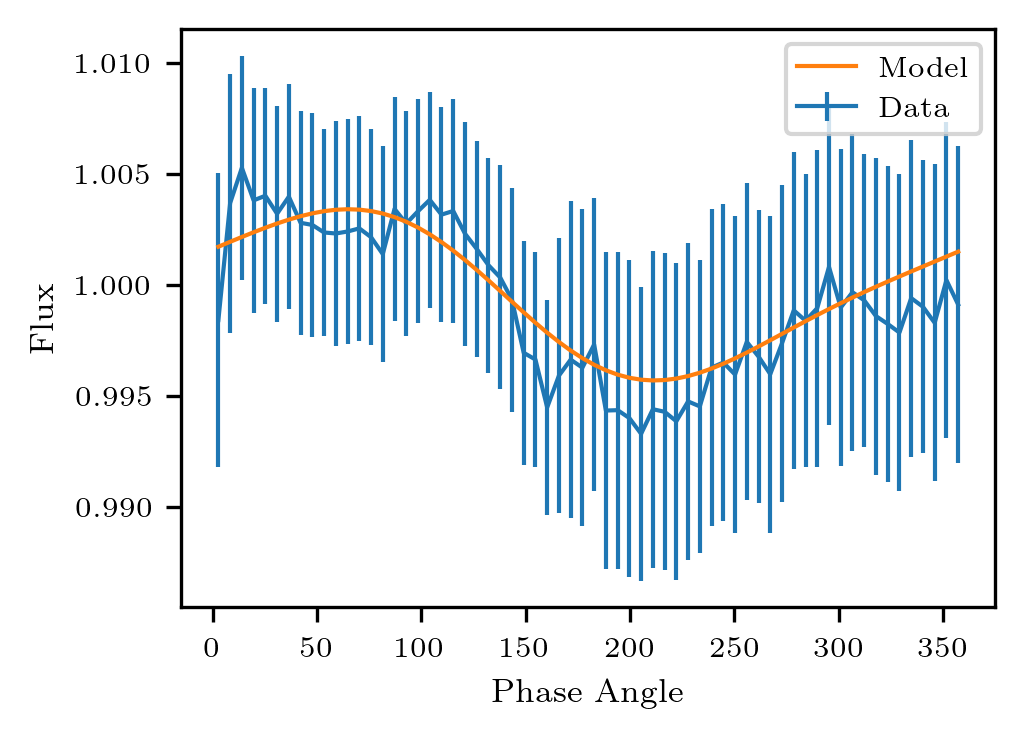

In [6]:
wl_test = 4.4
i_wl = np.argmin(np.abs(wl - wl_test))
map = make_map(mode='rotational', map_res=30, ydeg=2, inc=90)
map.solve_posterior(data.flux[i_wl], data.flux_err[i_wl], data.theta, verbose=False)
map.plot_lightcurve()

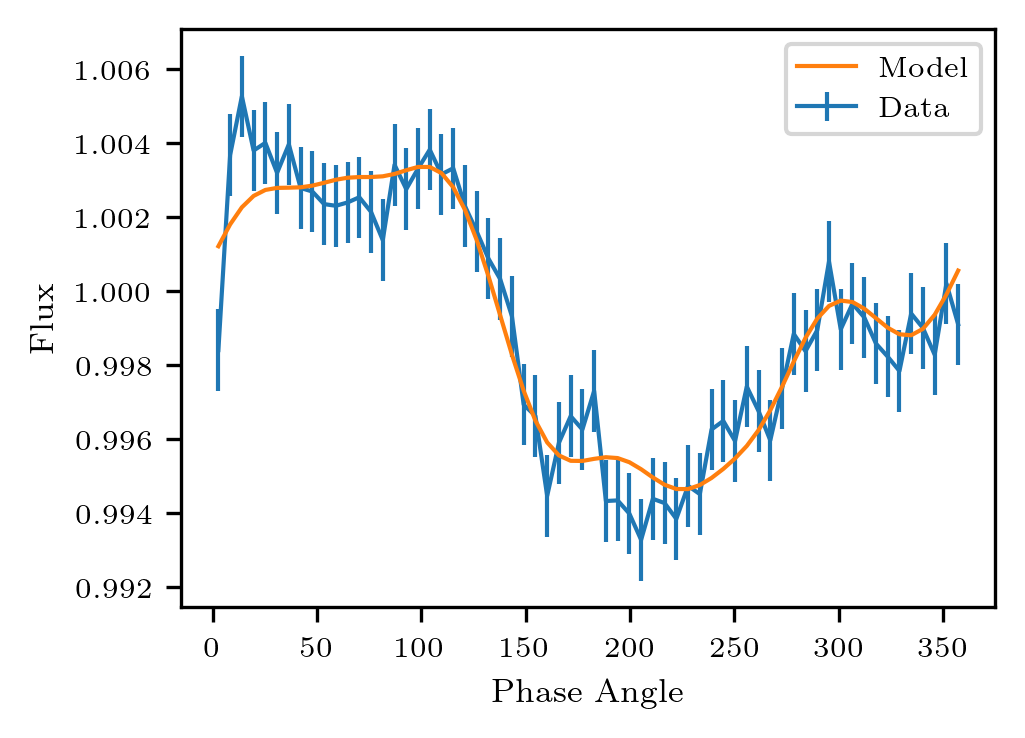

In [7]:
map = make_map(mode='rotational', map_res=30, ydeg=10, inc=90)
map.solve_posterior(data.flux[i_wl], None, data.theta, verbose=False)
map.plot_lightcurve()

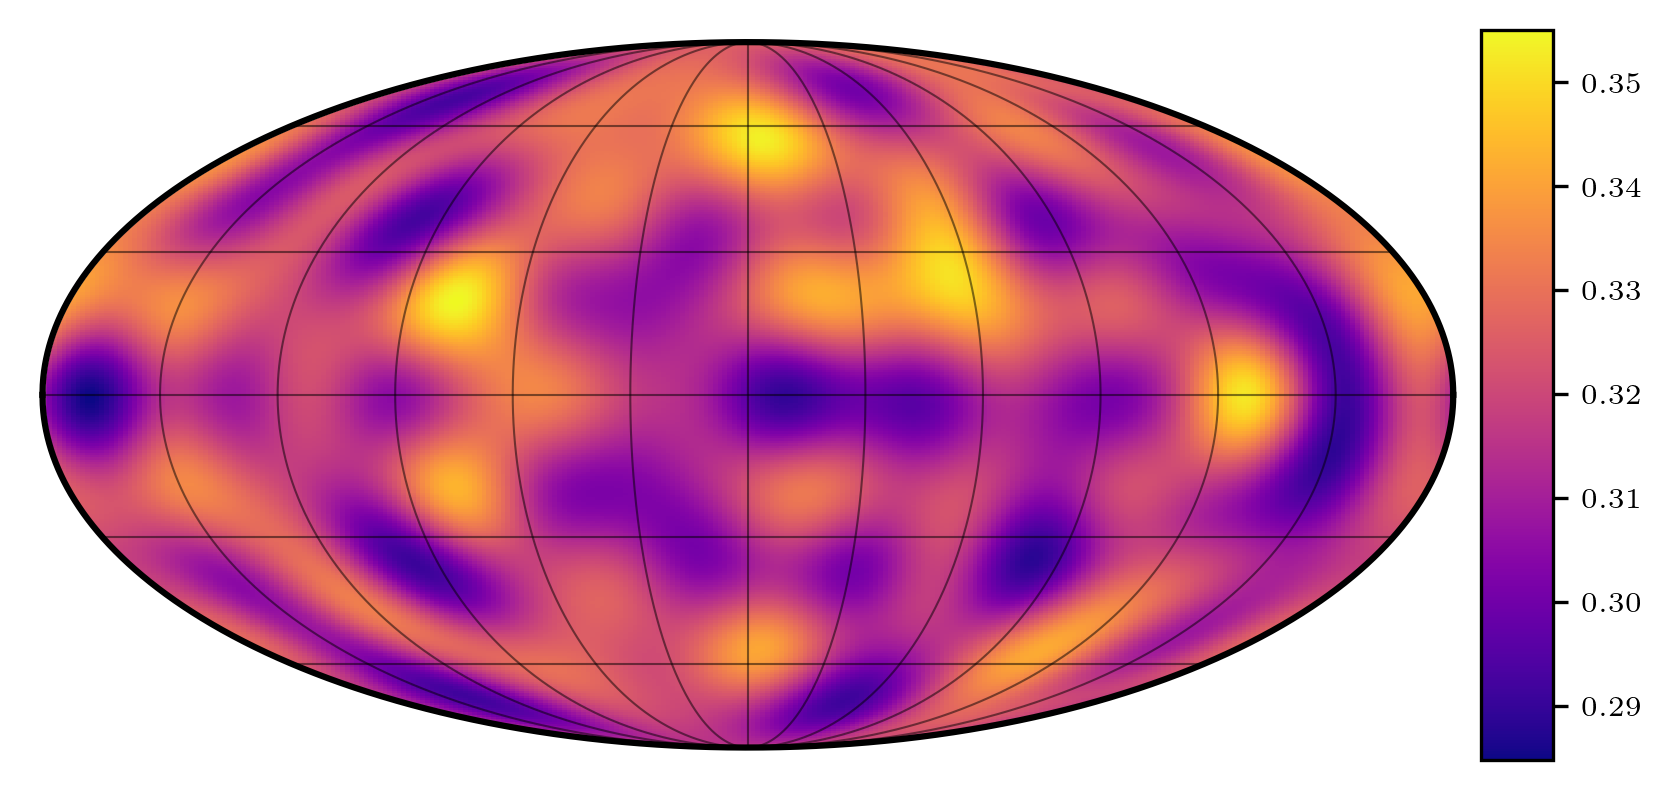

In [8]:
_ = map.draw(plot=True, projection="moll", grid=True, colorbar=True, n_samples=1)

### Find Optimal Map Complexity
We now solve for the maps. Since we don't know the complexity of the surface beforehand, we test spherical harmonic degrees ranging from `ydeg=2` to `ydeg=10`. The algorithm will automatically select the degree that best fits the data without overfitting (using the Bayesian Information Criterion).

In [9]:
from spectralmap.mapping import make_maps
maps = make_maps(mode='rotational', map_res=30, ydegs=np.arange(2, 10))

In [10]:
# Solve for the best spherical harmonic degree (ydeg) for each wavelength
# This optimizes the model complexity (model evidence) to avoid overfitting
w_all, I_all_wl, I_cov_all_wl = maps.marginalized_maps(data)

ydeg: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it, wl 363/363]


lambda=None: Best-evidence wavelength counts by ydeg: ydeg=2: 359, ydeg=4: 4, ydeg=6: 0, ydeg=8: 0


## 3. Visualize the Maps
Let's take a look at the recovered maps for a few wavelengths to see how the surface features change.

In [11]:
# for i, ydeg in enumerate(ydeg_best[:10]):
#     if ydeg <= 5:
#         plt.figure()
#         plt.imshow(I_all_wl[i].reshape((30, 30)), origin='lower')
#         plt.title(f"Wavelength {wl[i]: .2f}: best ydeg = {ydeg}")

## 4. Spectral Extraction
We convert the retrieved intensity maps ($I$) back into physical flux units ($F$) and calculate the associated variances. This gives us the spatially-resolved spectra.

In [12]:
F_all_wl = I_all_wl * amplitudes[:, None] *np.pi
F_cov_all_wl = I_cov_all_wl * (np.pi * amplitudes[:, None, None])**2
F_var_all_wl = np.diagonal(F_cov_all_wl, axis1=1, axis2=2)

In [13]:
from spectralmap.mapping import expand_moll_values
F_all_wl_grid = expand_moll_values(F_all_wl, maps.moll_mask_flat)
F_var_all_wl_grid = expand_moll_values(F_var_all_wl, maps.moll_mask_flat)

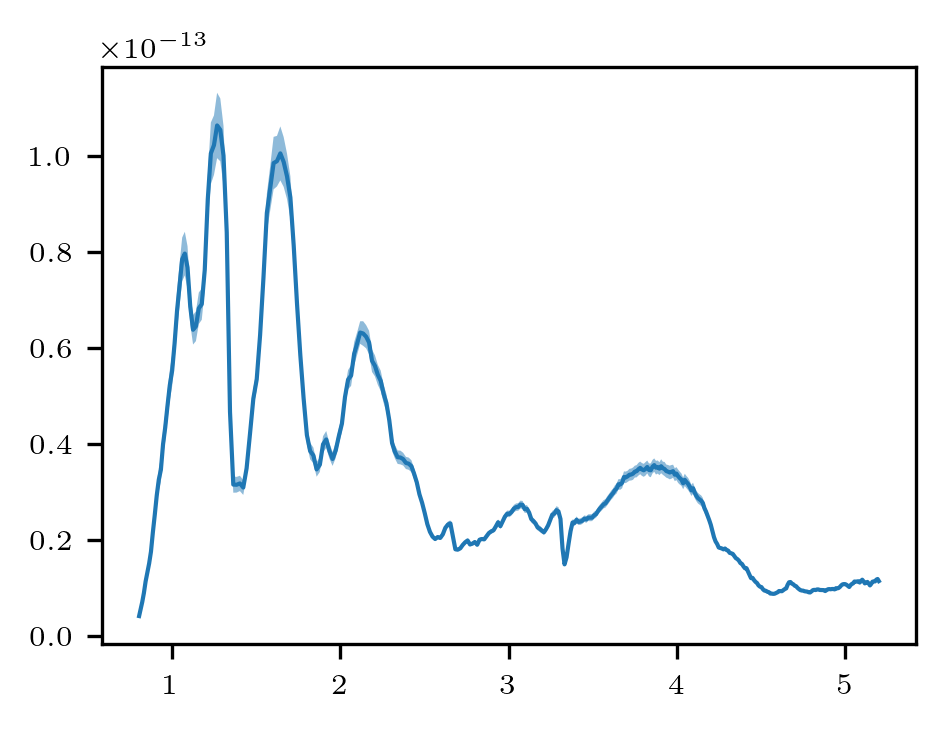

In [17]:
import matplotlib.pyplot as plt
i_grid = -1
plt.plot(wl[:], F_all_wl[:, i_grid])
plt.fill_between(wl[:], F_all_wl[:, i_grid] - np.sqrt(F_var_all_wl[:, i_grid]), F_all_wl[:, i_grid] + np.sqrt(F_var_all_wl[:, i_grid]), alpha=0.5)

## 5. Clustering and Regional Identification
To make sense of the map, we group pixels that show similar spectral behavior using a clustering algorithm. This helps us identify distinct "regions" or features on the object's surface.

-1 99
0 300
1 300


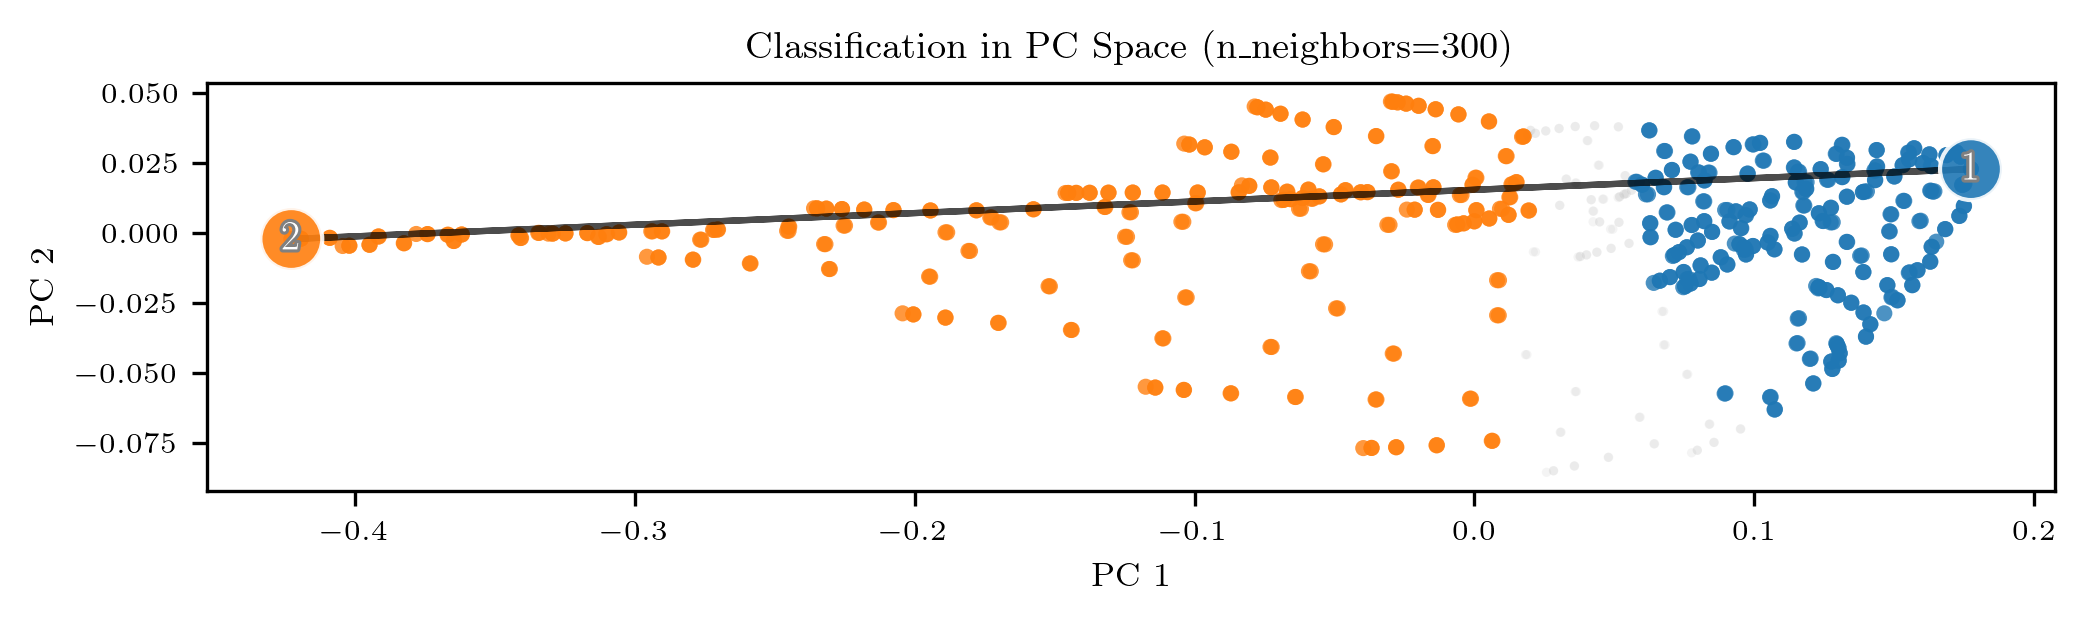

In [18]:
from spectralmap.cluster import find_clusters
F_regionals, F_regional_errs, labels = find_clusters(F_all_wl, F_cov_all_wl, n_neighbors=300, n_corners=2)
N = len(F_regionals)

In [19]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit_transform(np.log10(F_all_wl).T)
pca.explained_variance_ratio_

array([0.95514558, 0.03591218])

## 6. Results
Finally, we visualize the identified clusters on the map and plot the mean spectrum for each region.

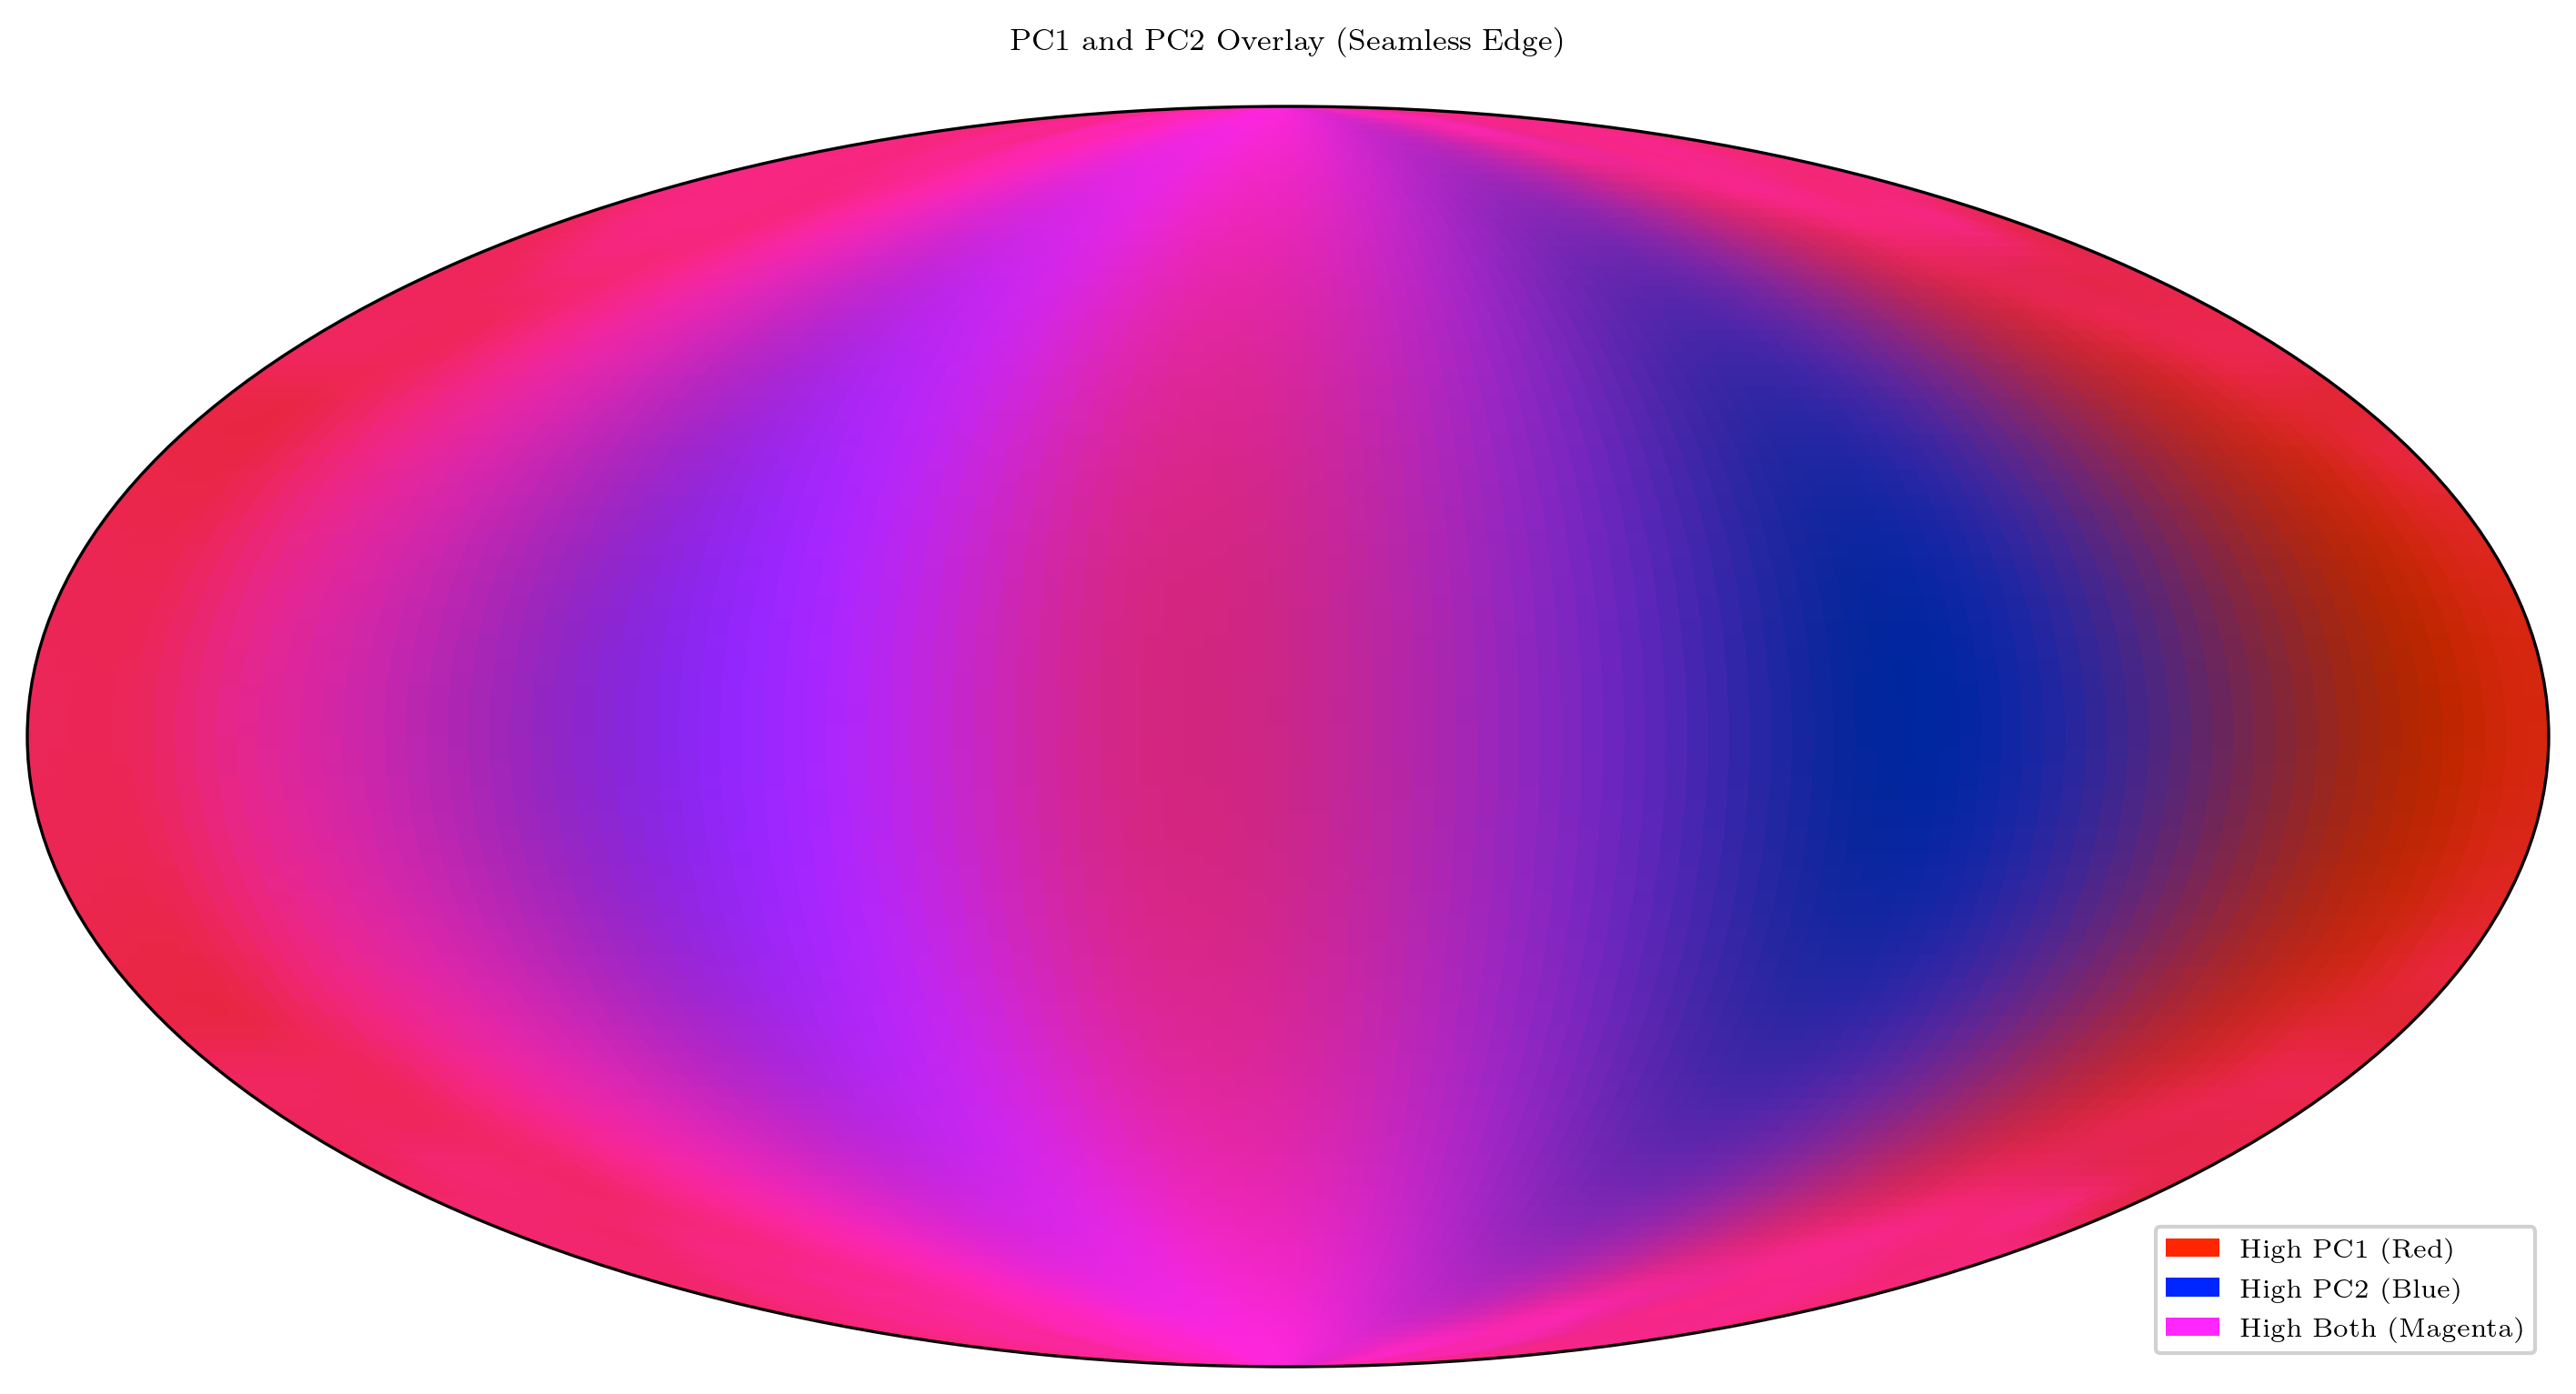

In [20]:
from sklearn.decomposition import PCA
from spectralmap.utilities import expand_moll_values, plot_mollweide_rgb_perfect_edges
pca = PCA(n_components=2)
PCs = pca.fit_transform(np.log(F_all_wl).T)  # shape: (n_wavelengths, 2)
pc1_scores = PCs[:, 0]
pc2_scores = PCs[:, 1]

mask_2d = maps.moll_mask
fig, ax = plot_mollweide_rgb_perfect_edges(pc1_scores, pc2_scores, mask_2d, upsample=4)
plt.show()

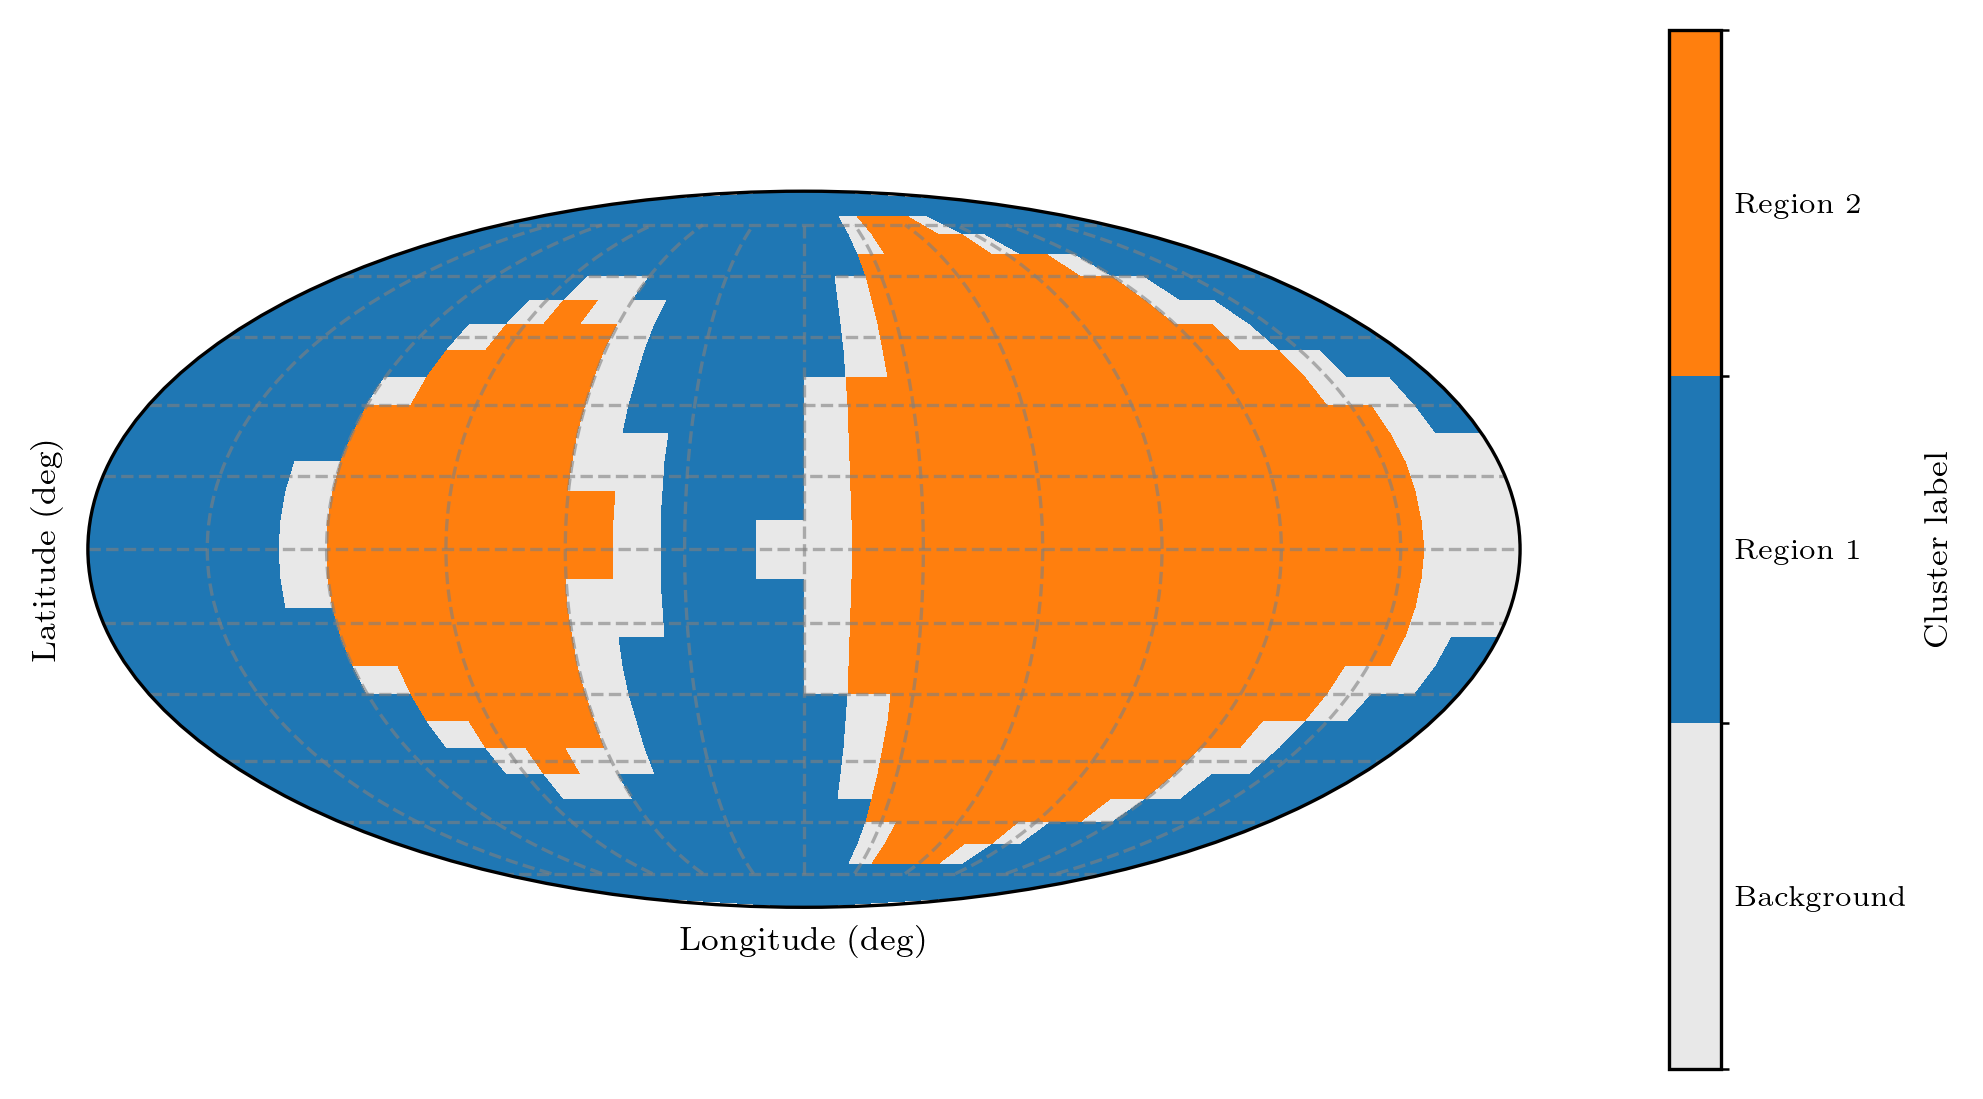

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from spectralmap.utilities import plot_mollweide_labels
from matplotlib import colors as mcolors

colors_list = ['#E8E8E8']  # Background
region_colors = plt.get_cmap('tab10').colors
for i in range(N - 1):
    colors_list.append(region_colors[i % len(region_colors)])

cluster_names = ["Background"] + [f"Region {i+1}" for i in range(N - 1)]
cmap = mcolors.ListedColormap(colors_list)

fig, ax, pcm, cb = plot_mollweide_labels(
    labels_masked=labels,      # should be ints 0..N-1 on masked pixels
    moll_mask=maps.moll_mask,
    map_res=map.map_res,
    cmap=cmap,
    names=cluster_names
)

output_dir = "paper_plots"
# os.makedirs(output_dir, exist_ok=True)
# output_path = os.path.join(output_dir, "S0136_recovered_regions.pdf")

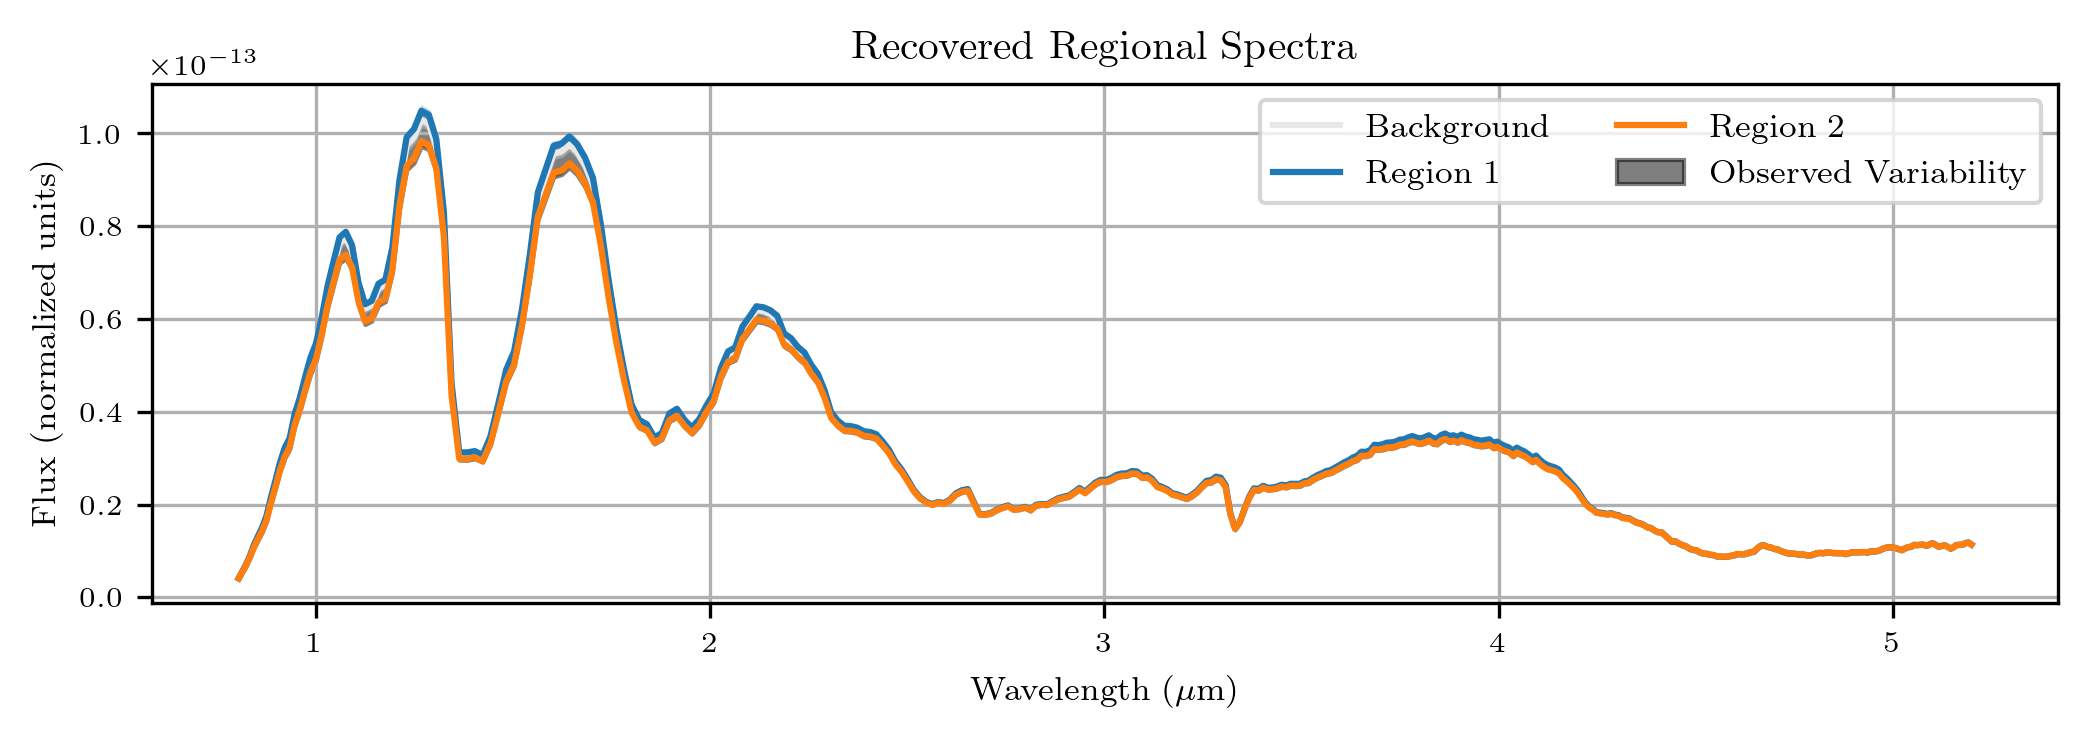

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import xarray as xr
import os

fig, ax = plt.subplots(figsize=(7, 2.5))

# Plot the recovered spectra for each region
for i in range(N):
    mean_flux = F_regionals[i]
    error_flux = F_regional_errs[i] # Fixed variable name
    color = colors_list[i]
    label = cluster_names[i]
    
    ax.plot(wl, mean_flux, label=f"{label}", color=color, linewidth=1.5)
    ax.fill_between(wl, 
                    mean_flux - error_flux, 
                    mean_flux + error_flux, 
                    alpha=0.3, color=color)
    
# Overlay the range of the observed time-series variability
time_series = np.sort(flux_raw.T, axis=0)
ax.fill_between(wl, time_series[0, :],
            time_series[-1, :], color='black', alpha=0.5, zorder=0, label="Observed Variability")

# Formatting
ax.set_xlabel(r"Wavelength ($\mu$m)")
ax.set_ylabel("Flux (normalized units)")
ax.set_title("Recovered Regional Spectra", fontsize=10)
ax.legend(fontsize=8, loc='upper right', ncol=2)

plt.tight_layout()
plt.grid()
output_dir = "paper_plots"
os.makedirs(output_dir, exist_ok=True)
# output_path = os.path.join(output_dir, "S0136_recovered_spectra.pdf")
# plt.savefig(output_path, dpi=600)

plt.show()